<a href="https://colab.research.google.com/github/maruf4461/AI-Enhanced-Data-Driven-Decision-Making-in-MIS/blob/main/AI_Enhanced_DDD_for_MIS_Data_collection_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================================
# AI-Enhanced Data-Driven Decision Making in MIS Research
# Phase 1: Data Infrastructure & Collection
# Author: Md Maruf Islam
# Date: July 2025
# ============================================================================


In [2]:
# CELL 1: Install Required Packages
# ============================================================================
!pip install yfinance pandas numpy requests beautifulsoup4 tqdm matplotlib seaborn
!pip install pandas-datareader fredapi openpyxl xlsxwriter
!pip install textstat nltk wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.0 MB/s eta 0:00:00


# CELL 2: Import Libraries and Setup Google Drive


In [3]:
# CELL 2: Import Libraries and Setup Google Drive
# ============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import time
import os
import json
from datetime import datetime, timedelta
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive, files
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Create project directory structure
project_path = '/content/drive/MyDrive/AI_MIS_Research'
folders = ['raw_data', 'processed_data', 'results', 'code', 'documentation']

for folder in folders:
    os.makedirs(f'{project_path}/{folder}', exist_ok=True)

print("✅ Google Drive mounted and project structure created!")
print(f"📁 Project directory: {project_path}")


Mounted at /content/drive
✅ Google Drive mounted and project structure created!
📁 Project directory: /content/drive/MyDrive/AI_MIS_Research


# CELL 3: Configuration and Helper Functions

In [4]:
# CELL 3: Configuration and Helper Functions
# ============================================================================
# Research configuration
CONFIG = {
    'start_date': '2018-01-01',
    'end_date': '2025-07-23',
    'rate_limit_delay': 0.5,  # seconds between API calls
    'batch_size': 50,         # companies per batch
    'max_retries': 3,
    'timeout': 30
}

# Save configuration
with open(f'{project_path}/documentation/config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

def rate_limit_delay():
    """Implement rate limiting for API calls"""
    time.sleep(CONFIG['rate_limit_delay'])

def save_data(data, filename, folder='raw_data'):
    """Save data with timestamp and backup"""
    filepath = f"{project_path}/{folder}/{filename}"
    if isinstance(data, pd.DataFrame):
        data.to_csv(filepath, index=False)
    else:
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=2)
    print(f"💾 Saved: {filename}")

def load_data(filename, folder='raw_data'):
    """Load data from saved files"""
    filepath = f"{project_path}/{folder}/{filename}"
    if filename.endswith('.csv'):
        return pd.read_csv(filepath)
    else:
        with open(filepath, 'r') as f:
            return json.load(f)

print("⚙️ Configuration and helper functions loaded!")


⚙️ Configuration and helper functions loaded!


# CELL 4: Get S&P 500 Company List

In [5]:
# CELL 4: Get S&P 500 Company List
# ============================================================================
def get_sp500_companies():
    """Fetch current S&P 500 company list from Wikipedia"""
    print("🔍 Fetching S&P 500 company list...")

    try:
        # Get S&P 500 list from Wikipedia
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        tables = pd.read_html(url)
        sp500_df = tables[0]

        # Clean and standardize column names
        sp500_df.columns = ['Symbol', 'Security', 'GICS_Sector', 'GICS_Sub_Industry',
                           'Headquarters', 'Date_Added', 'CIK', 'Founded']

        # Clean the data
        sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-')  # Yahoo Finance format
        sp500_df = sp500_df.dropna(subset=['Symbol'])

        print(f"✅ Successfully fetched {len(sp500_df)} S&P 500 companies")
        print(f"📊 Sectors: {sp500_df['GICS_Sector'].nunique()} unique sectors")

        # Display sector distribution
        sector_counts = sp500_df['GICS_Sector'].value_counts()
        print("\n📈 Sector Distribution:")
        for sector, count in sector_counts.head(10).items():
            print(f"  • {sector}: {count} companies")

        return sp500_df

    except Exception as e:
        print(f"❌ Error fetching S&P 500 list: {e}")
        return None

# Execute function
sp500_companies = get_sp500_companies()
if sp500_companies is not None:
    save_data(sp500_companies, 'sp500_companies.csv')
    print(f"📊 Sample companies:\n{sp500_companies[['Symbol', 'Security', 'GICS_Sector']].head()}")


🔍 Fetching S&P 500 company list...
✅ Successfully fetched 503 S&P 500 companies
📊 Sectors: 11 unique sectors

📈 Sector Distribution:
  • Industrials: 78 companies
  • Financials: 74 companies
  • Information Technology: 68 companies
  • Health Care: 60 companies
  • Consumer Discretionary: 51 companies
  • Consumer Staples: 38 companies
  • Utilities: 31 companies
  • Real Estate: 31 companies
  • Materials: 26 companies
  • Communication Services: 24 companies
💾 Saved: sp500_companies.csv
📊 Sample companies:
  Symbol             Security             GICS_Sector
0    MMM                   3M             Industrials
1    AOS          A. O. Smith             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV               AbbVie             Health Care
4    ACN            Accenture  Information Technology


# CELL 5: Financial Data Collection Function

In [6]:
# CELL 5: Financial Data Collection Function
# ============================================================================
def collect_financial_data(symbols_batch, batch_num=1, total_batches=1):
    """Collect comprehensive financial data for a batch of companies"""

    print(f"\n💰 Collecting financial data - Batch {batch_num}/{total_batches}")
    print(f"📊 Processing {len(symbols_batch)} companies...")

    financial_data = []
    failed_symbols = []

    for i, symbol in enumerate(tqdm(symbols_batch, desc="Fetching financial data")):
        try:
            rate_limit_delay()

            # Create ticker object
            ticker = yf.Ticker(symbol)

            # Get basic info
            info = ticker.info

            # Get historical data
            hist_data = ticker.history(start=CONFIG['start_date'],
                                     end=CONFIG['end_date'],
                                     auto_adjust=True)

            if len(hist_data) == 0:
                failed_symbols.append(symbol)
                continue

            # Get financial statements
            financials = ticker.financials
            balance_sheet = ticker.balance_sheet
            cashflow = ticker.cashflow

            # Extract key metrics
            company_data = {
                'Symbol': symbol,
                'Company_Name': info.get('longName', 'N/A'),
                'Industry': info.get('industry', 'N/A'),
                'Sector': info.get('sector', 'N/A'),
                'Market_Cap': info.get('marketCap', None),
                'Enterprise_Value': info.get('enterpriseValue', None),
                'Revenue_TTM': info.get('totalRevenue', None),
                'Gross_Profit': info.get('grossProfits', None),
                'Operating_Income': info.get('operatingIncome', None),
                'Net_Income': info.get('netIncomeToCommon', None),
                'Total_Assets': info.get('totalAssets', None),
                'Total_Debt': info.get('totalDebt', None),
                'ROE': info.get('returnOnEquity', None),
                'ROA': info.get('returnOnAssets', None),
                'Profit_Margin': info.get('profitMargins', None),
                'Operating_Margin': info.get('operatingMargins', None),
                'Current_Ratio': info.get('currentRatio', None),
                'Debt_to_Equity': info.get('debtToEquity', None),
                'Price_to_Book': info.get('priceToBook', None),
                'PE_Ratio': info.get('trailingPE', None),
                'Beta': info.get('beta', None),
                'Employee_Count': info.get('fullTimeEmployees', None),
                'R&D_Expenses': None,  # Will extract from financials
                'Data_Collection_Date': datetime.now().strftime('%Y-%m-%d')
            }

            # Extract R&D expenses from financials if available
            if not financials.empty and 'Research And Development' in financials.index:
                rd_expenses = financials.loc['Research And Development'].iloc[0] if len(financials.columns) > 0 else None
                company_data['R&D_Expenses'] = rd_expenses

            # Calculate additional financial ratios
            if company_data['Revenue_TTM'] and company_data['R&D_Expenses']:
                company_data['RD_Intensity'] = company_data['R&D_Expenses'] / company_data['Revenue_TTM']

            # Add stock performance metrics
            if len(hist_data) > 252:  # At least 1 year of data
                recent_price = hist_data['Close'].iloc[-1]
                year_ago_price = hist_data['Close'].iloc[-252]
                company_data['Stock_Return_1Y'] = (recent_price - year_ago_price) / year_ago_price
                company_data['Stock_Volatility'] = hist_data['Close'].pct_change().std() * np.sqrt(252)

            financial_data.append(company_data)

        except Exception as e:
            print(f"⚠️ Error processing {symbol}: {str(e)[:100]}...")
            failed_symbols.append(symbol)
            continue

    print(f"✅ Successfully processed: {len(financial_data)}/{len(symbols_batch)} companies")
    if failed_symbols:
        print(f"❌ Failed symbols: {failed_symbols[:10]}{'...' if len(failed_symbols) > 10 else ''}")

    return pd.DataFrame(financial_data), failed_symbols


# CELL 6: Execute Financial Data Collection in Batches

In [7]:
# CELL 6: Execute Financial Data Collection in Batches
# ============================================================================
if sp500_companies is not None:
    # Prepare symbol batches
    symbols = sp500_companies['Symbol'].tolist()
    total_companies = len(symbols)
    batch_size = CONFIG['batch_size']
    batches = [symbols[i:i+batch_size] for i in range(0, len(symbols), batch_size)]
    total_batches = len(batches)

    print(f"🚀 Starting financial data collection for {total_companies} companies")
    print(f"📦 Processing in {total_batches} batches of {batch_size} companies each")

    all_financial_data = []
    all_failed_symbols = []

    for batch_num, batch_symbols in enumerate(batches, 1):
        print(f"\n{'='*60}")
        print(f"BATCH {batch_num}/{total_batches}")
        print(f"{'='*60}")

        batch_data, failed_symbols = collect_financial_data(
            batch_symbols, batch_num, total_batches
        )

        if not batch_data.empty:
            all_financial_data.append(batch_data)

            # Save batch results
            batch_filename = f'financial_data_batch_{batch_num}.csv'
            save_data(batch_data, batch_filename)

        all_failed_symbols.extend(failed_symbols)

        # Progress update
        processed_so_far = sum(len(df) for df in all_financial_data)
        print(f"📊 Progress: {processed_so_far}/{total_companies} companies processed")

        # Save progress periodically
        if batch_num % 5 == 0 or batch_num == total_batches:
            if all_financial_data:
                combined_data = pd.concat(all_financial_data, ignore_index=True)
                save_data(combined_data, 'financial_data_combined_progress.csv')
                print(f"💾 Progress saved: {len(combined_data)} companies")

    # Combine all batch results
    if all_financial_data:
        final_financial_data = pd.concat(all_financial_data, ignore_index=True)
        save_data(final_financial_data, 'sp500_financial_data_complete.csv')

        print(f"\n🎉 FINANCIAL DATA COLLECTION COMPLETE!")
        print(f"✅ Successfully collected data for: {len(final_financial_data)} companies")
        print(f"❌ Failed to collect data for: {len(all_failed_symbols)} companies")
        print(f"📊 Success rate: {len(final_financial_data)/total_companies*100:.1f}%")

        # Save failed symbols for retry
        if all_failed_symbols:
            save_data(all_failed_symbols, 'failed_symbols.json')


🚀 Starting financial data collection for 503 companies
📦 Processing in 11 batches of 50 companies each

BATCH 1/11

💰 Collecting financial data - Batch 1/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_1.csv
📊 Progress: 50/503 companies processed

BATCH 2/11

💰 Collecting financial data - Batch 2/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_2.csv
📊 Progress: 100/503 companies processed

BATCH 3/11

💰 Collecting financial data - Batch 3/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_3.csv
📊 Progress: 150/503 companies processed

BATCH 4/11

💰 Collecting financial data - Batch 4/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_4.csv
📊 Progress: 200/503 companies processed

BATCH 5/11

💰 Collecting financial data - Batch 5/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_5.csv
📊 Progress: 250/503 companies processed
💾 Saved: financial_data_combined_progress.csv
💾 Progress saved: 250 companies

BATCH 6/11

💰 Collecting financial data - Batch 6/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_6.csv
📊 Progress: 300/503 companies processed

BATCH 7/11

💰 Collecting financial data - Batch 7/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_7.csv
📊 Progress: 350/503 companies processed

BATCH 8/11

💰 Collecting financial data - Batch 8/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_8.csv
📊 Progress: 400/503 companies processed

BATCH 9/11

💰 Collecting financial data - Batch 9/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_9.csv
📊 Progress: 450/503 companies processed

BATCH 10/11

💰 Collecting financial data - Batch 10/11
📊 Processing 50 companies...


Fetching financial data: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


✅ Successfully processed: 50/50 companies
💾 Saved: financial_data_batch_10.csv
📊 Progress: 500/503 companies processed
💾 Saved: financial_data_combined_progress.csv
💾 Progress saved: 500 companies

BATCH 11/11

💰 Collecting financial data - Batch 11/11
📊 Processing 3 companies...


Fetching financial data: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

✅ Successfully processed: 3/3 companies
💾 Saved: financial_data_batch_11.csv
📊 Progress: 503/503 companies processed
💾 Saved: financial_data_combined_progress.csv
💾 Progress saved: 503 companies
💾 Saved: sp500_financial_data_complete.csv

🎉 FINANCIAL DATA COLLECTION COMPLETE!
✅ Successfully collected data for: 503 companies
❌ Failed to collect data for: 0 companies
📊 Success rate: 100.0%


# CELL 7: Data Quality Assessment and Summary

🔍 DATA QUALITY ASSESSMENT
📊 Dataset Shape: (503, 27)
🏢 Companies: 503
🏭 Sectors: 11
🏗️ Industries: 114

📉 Missing Data Analysis:
  • Enterprise_Value: 6 (1.2%)
  • Operating_Income: 503 (100.0%)
  • Total_Assets: 503 (100.0%)
  • Total_Debt: 6 (1.2%)
  • ROE: 34 (6.8%)
  • ROA: 7 (1.4%)
  • Current_Ratio: 26 (5.2%)
  • Debt_to_Equity: 55 (10.9%)
  • PE_Ratio: 25 (5.0%)
  • Beta: 29 (5.8%)
  • Employee_Count: 5 (1.0%)
  • R&D_Expenses: 336 (66.8%)
  • RD_Intensity: 336 (66.8%)

💰 Key Financial Metrics Availability:
  • Market_Cap: 503/503 (100.0%)
  • Revenue_TTM: 503/503 (100.0%)
  • Net_Income: 503/503 (100.0%)
  • ROE: 469/503 (93.2%)
  • ROA: 496/503 (98.6%)
  • R&D_Expenses: 167/503 (33.2%)

🏭 Sector Distribution:
  • Technology: 82 (16.3%)
  • Industrials: 71 (14.1%)
  • Financial Services: 68 (13.5%)
  • Healthcare: 61 (12.1%)
  • Consumer Cyclical: 56 (11.1%)
  • Consumer Defensive: 37 (7.4%)
  • Utilities: 31 (6.2%)
  • Real Estate: 31 (6.2%)
  • Communication Services: 24 (4.8

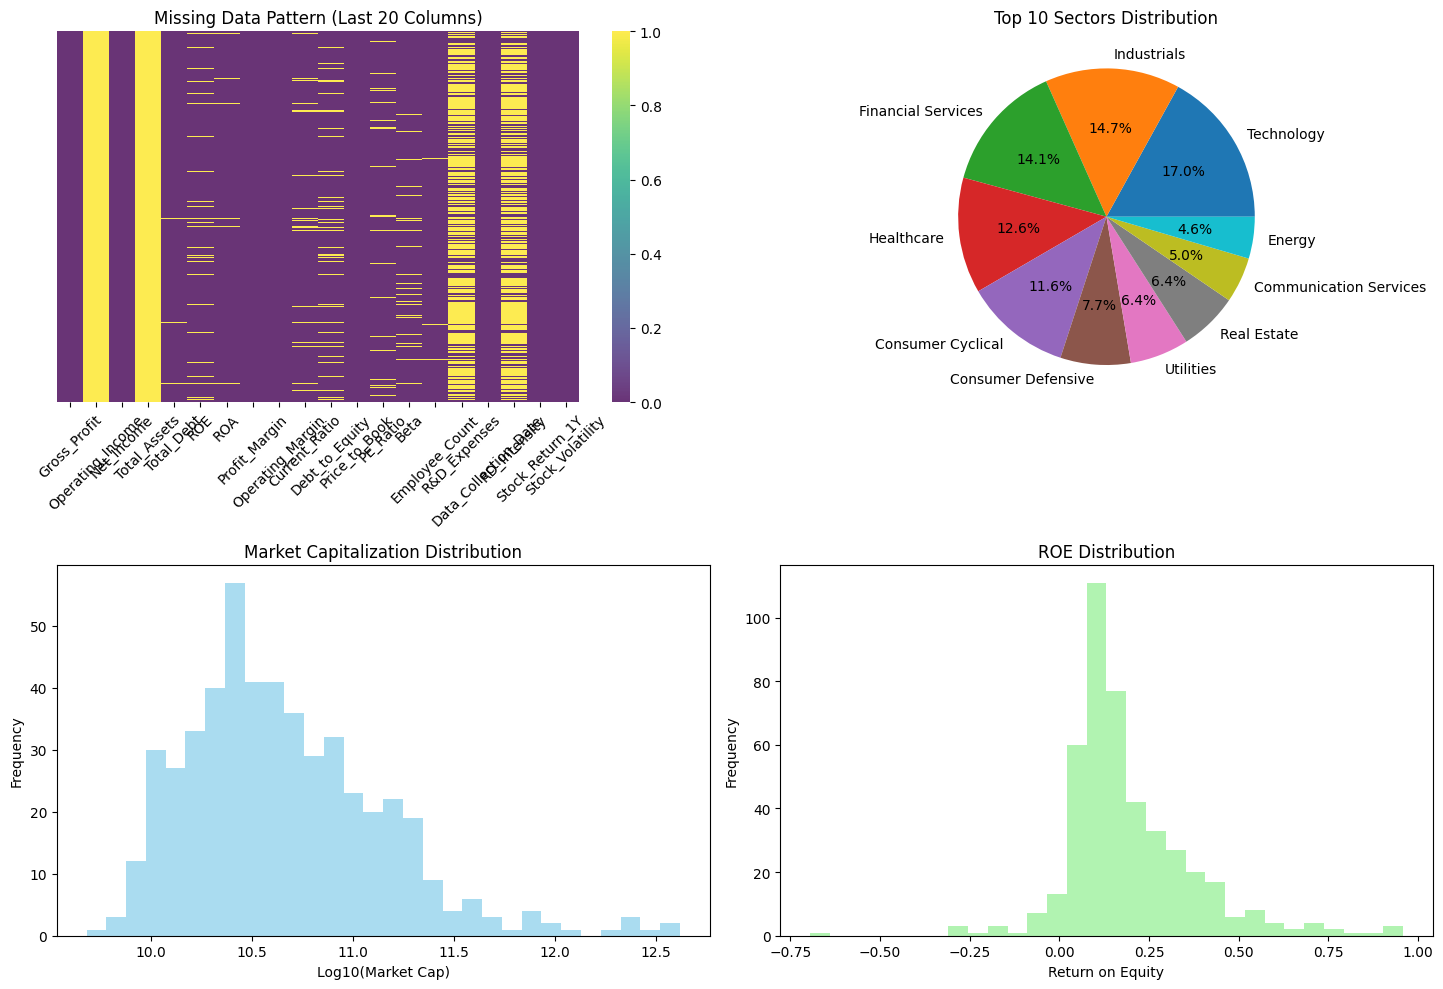


📊 Data quality summary saved to: /content/drive/MyDrive/AI_MIS_Research/results/


In [8]:
# CELL 7: Data Quality Assessment and Summary
# ============================================================================
def assess_data_quality(df):
    """Comprehensive data quality assessment"""
    print("🔍 DATA QUALITY ASSESSMENT")
    print("="*50)

    # Basic statistics
    print(f"📊 Dataset Shape: {df.shape}")
    print(f"🏢 Companies: {df['Symbol'].nunique()}")
    print(f"🏭 Sectors: {df['Sector'].nunique()}")
    print(f"🏗️ Industries: {df['Industry'].nunique()}")

    # Missing data analysis
    print(f"\n📉 Missing Data Analysis:")
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100

    for col in missing_data[missing_data > 0].index:
        print(f"  • {col}: {missing_data[col]} ({missing_pct[col]:.1f}%)")

    # Key financial metrics availability
    key_metrics = ['Market_Cap', 'Revenue_TTM', 'Net_Income', 'ROE', 'ROA', 'R&D_Expenses']
    print(f"\n💰 Key Financial Metrics Availability:")
    for metric in key_metrics:
        if metric in df.columns:
            available = df[metric].notna().sum()
            pct = (available / len(df)) * 100
            print(f"  • {metric}: {available}/{len(df)} ({pct:.1f}%)")

    # Sector distribution
    print(f"\n🏭 Sector Distribution:")
    sector_dist = df['Sector'].value_counts()
    for sector, count in sector_dist.head(10).items():
        pct = (count / len(df)) * 100
        print(f"  • {sector}: {count} ({pct:.1f}%)")

    return missing_data, missing_pct

# Execute data quality assessment
if 'final_financial_data' in locals():
    missing_data, missing_pct = assess_data_quality(final_financial_data)

    # Create summary visualization
    plt.figure(figsize=(15, 10))

    # Subplot 1: Missing data heatmap
    plt.subplot(2, 2, 1)
    missing_matrix = final_financial_data.isnull()
    sns.heatmap(missing_matrix.iloc[:, -20:], cbar=True, yticklabels=False,
                cmap='viridis', alpha=0.8)
    plt.title('Missing Data Pattern (Last 20 Columns)')
    plt.xticks(rotation=45)

    # Subplot 2: Sector distribution
    plt.subplot(2, 2, 2)
    sector_counts = final_financial_data['Sector'].value_counts().head(10)
    plt.pie(sector_counts.values, labels=sector_counts.index, autopct='%1.1f%%')
    plt.title('Top 10 Sectors Distribution')

    # Subplot 3: Market cap distribution
    plt.subplot(2, 2, 3)
    market_caps = final_financial_data['Market_Cap'].dropna()
    plt.hist(np.log10(market_caps), bins=30, alpha=0.7, color='skyblue')
    plt.xlabel('Log10(Market Cap)')
    plt.ylabel('Frequency')
    plt.title('Market Capitalization Distribution')

    # Subplot 4: ROE distribution
    plt.subplot(2, 2, 4)
    roe_data = final_financial_data['ROE'].dropna()
    roe_data = roe_data[(roe_data > -1) & (roe_data < 1)]  # Remove extreme outliers
    plt.hist(roe_data, bins=30, alpha=0.7, color='lightgreen')
    plt.xlabel('Return on Equity')
    plt.ylabel('Frequency')
    plt.title('ROE Distribution')

    plt.tight_layout()
    plt.savefig(f'{project_path}/results/phase1_data_quality_summary.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Data quality summary saved to: {project_path}/results/")


# CELL 8: Phase 1 Completion Summary

In [9]:
# CELL 8: Phase 1 Completion Summary
# ============================================================================
def phase1_completion_report():
    """Generate comprehensive Phase 1 completion report"""
    print("\n" + "="*80)
    print("🎉 PHASE 1: DATA INFRASTRUCTURE & COLLECTION - COMPLETED!")
    print("="*80)

    # File inventory
    raw_data_path = f"{project_path}/raw_data"
    files_created = os.listdir(raw_data_path)

    print(f"\n📁 Files Created ({len(files_created)} files):")
    for file in sorted(files_created):
        file_path = os.path.join(raw_data_path, file)
        file_size = os.path.getsize(file_path) / (1024*1024)  # MB
        print(f"  • {file} ({file_size:.2f} MB)")

    # Summary statistics
    if 'final_financial_data' in locals():
        print(f"\n📊 Data Collection Summary:")
        print(f"  • Total companies processed: {len(final_financial_data)}")
        print(f"  • Success rate: {len(final_financial_data)/len(sp500_companies)*100:.1f}%")
        print(f"  • Data columns: {len(final_financial_data.columns)}")
        print(f"  • Date range: {CONFIG['start_date']} to {CONFIG['end_date']}")
        print(f"  • Sectors covered: {final_financial_data['Sector'].nunique()}")
        print(f"  • Industries covered: {final_financial_data['Industry'].nunique()}")

    print(f"\n⏱️ Next Steps:")
    print(f"  🔄 Phase 2: AI Adoption Measurement")
    print(f"  📊 Phase 3: Data Integration & Preparation")
    print(f"  📈 Phase 4: Descriptive & Exploratory Analysis")
    print(f"  🧮 Phase 5: Advanced Statistical Modeling")
    print(f"  📝 Phase 6: Results Synthesis & Visualization")

    print(f"\n✅ Phase 1 completed successfully!")
    print(f"📂 All data saved in: {project_path}")

    # Create completion timestamp
    completion_info = {
        'phase': 'Phase 1: Data Infrastructure & Collection',
        'completion_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'companies_processed': len(final_financial_data) if 'final_financial_data' in locals() else 0,
        'files_created': files_created,
        'next_phase': 'Phase 2: AI Adoption Measurement'
    }

    save_data(completion_info, 'phase1_completion.json', 'documentation')

# Execute completion report
phase1_completion_report()

print(f"\n🚀 Ready for Phase 2: AI Adoption Measurement!")
print(f"📋 When ready, request Phase 2 code to continue the research pipeline.")


🎉 PHASE 1: DATA INFRASTRUCTURE & COLLECTION - COMPLETED!

📁 Files Created (14 files):
  • financial_data_batch_1.csv (0.01 MB)
  • financial_data_batch_10.csv (0.01 MB)
  • financial_data_batch_11.csv (0.00 MB)
  • financial_data_batch_2.csv (0.01 MB)
  • financial_data_batch_3.csv (0.01 MB)
  • financial_data_batch_4.csv (0.01 MB)
  • financial_data_batch_5.csv (0.01 MB)
  • financial_data_batch_6.csv (0.01 MB)
  • financial_data_batch_7.csv (0.01 MB)
  • financial_data_batch_8.csv (0.01 MB)
  • financial_data_batch_9.csv (0.01 MB)
  • financial_data_combined_progress.csv (0.13 MB)
  • sp500_companies.csv (0.05 MB)
  • sp500_financial_data_complete.csv (0.13 MB)

⏱️ Next Steps:
  🔄 Phase 2: AI Adoption Measurement
  📊 Phase 3: Data Integration & Preparation
  📈 Phase 4: Descriptive & Exploratory Analysis
  🧮 Phase 5: Advanced Statistical Modeling
  📝 Phase 6: Results Synthesis & Visualization

✅ Phase 1 completed successfully!
📂 All data saved in: /content/drive/MyDrive/AI_MIS_Resear